In [91]:
import pandas as pd

train_dataset = '/home/ziyue/zhang/resnet/cnn_ceni_phi_2015_train90.csv'

df = pd.read_csv(train_dataset)
df = df.dropna(subset=['POV_2015'])

# Set the id = rownumber as index of the DataFrame
id_to_pov = df.set_index('id')['POV_2015'].to_dict()
print(id_to_pov)


{247: 15.44, 248: 15.44, 250: 13.1, 251: 13.1, 252: 12.54, 253: 12.54, 255: 12.54, 257: 10.62, 261: 8.5, 262: 8.5, 263: 8.5, 264: 8.5, 265: 8.5, 266: 8.5, 267: 27.08, 268: 27.08, 269: 27.08, 271: 27.08, 272: 27.08, 273: 27.08, 274: 27.08, 275: 17.38, 276: 17.38, 278: 17.38, 279: 17.38, 280: 17.38, 281: 16.42, 282: 14.38, 283: 12.46, 284: 15.44, 285: 15.44, 286: 15.44, 287: 15.44, 288: 15.44, 289: 15.44, 291: 13.1, 292: 13.1, 293: 13.1, 294: 13.1, 295: 12.54, 296: 12.54, 297: 12.54, 298: 12.54, 299: 7.48, 301: 8.5, 302: 8.5, 303: 8.5, 304: 8.5, 305: 8.5, 307: 20.34, 308: 20.34, 309: 27.08, 310: 27.08, 311: 27.08, 312: 27.08, 313: 27.08, 315: 27.08, 316: 27.08, 317: 17.38, 318: 17.38, 320: 17.38, 321: 17.38, 322: 17.38, 323: 16.42, 324: 12.46, 325: 12.46, 326: 15.44, 327: 15.44, 329: 11.92, 330: 11.92, 331: 11.92, 332: 11.92, 333: 15.81, 334: 15.81, 335: 15.81, 336: 13.1, 337: 13.1, 338: 13.1, 339: 13.1, 340: 13.1, 341: 13.1, 342: 13.1, 343: 13.1, 344: 12.54, 345: 12.54, 346: 6.61, 347: 

In [92]:
import os
import shutil
os.makedirs('data', exist_ok=True)
tar_file = '/home/ziyue/zhang/resnet/CNN_IMGB_PHI_2015_ST_384_JPG_3840.tar.gz'
imagery_path = '/home/ziyue/zhang/resnet/data'
#shutil.unpack_archive(tar_file, 'data')

In [93]:
import glob

matched_files = {}

jpg_files = glob.glob1(imagery_path,"*.jpg")
print("Total images are " + str(len(jpg_files)))
for file in jpg_files:
    file_id = int(file.split('_')[-1].split('.')[0])

    if file_id in id_to_pov:
            # Match the jpg file with the corresponding pov value
            matched_files[file] = id_to_pov[file_id]

print("Train dataset has " + str(len(matched_files)) + " data pairs")



Total images are 20090
Train dataset has 18062 data pairs


In [94]:
import os
import torch
import torchvision.transforms as transforms
from torch.utils.data import Dataset
from PIL import Image
from torch.utils.data import DataLoader, random_split, Dataset
from collections import defaultdict


class CustomDataset(Dataset):
    def __init__(self, matched_files, img_dir, transform=None):
        self.matched_files = matched_files
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.matched_files)

    def __getitem__(self, idx):
        filename, target_value = list(self.matched_files.items())[idx]
        img_path = os.path.join(self.img_dir, filename)
        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)
            
        target_value = torch.tensor([target_value], dtype=torch.float32)
        return image, target_value

# Define any necessary image transformations
transform = transforms.Compose([
    #transforms.Resize((224, 224)),  # Resize the image (optional)
    transforms.ToTensor(),  # Convert image to a PyTorch tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize the image (optional, but recommended for most pre-trained models)
])

# Create an instance of the dataset
dataset = CustomDataset(matched_files=matched_files, img_dir='/home/ziyue/zhang/resnet/data', transform=transform)


val_percent: float = 0.2 #Use 20% as validation dataset
batch_size = 32


n_val = int(len(dataset) * val_percent)   #这几行就是定义多少个training 多少个validation
n_train = len(dataset) - n_val
train_set, val_set = random_split(dataset, [n_train, n_val], generator=torch.Generator().manual_seed(42))


#Dataloader了该 Dataloader的作用就是打包Batch
loader_args = dict(batch_size=batch_size, num_workers=4, pin_memory=True) #为下面的两行做准备
train_loader = DataLoader(train_set, shuffle=True, **loader_args)   #dataloader来load这个dataset，分为train和validation
val_loader = DataLoader(val_set, shuffle=False, drop_last=True, **loader_args)


dataloaders = {
  'train': train_loader,
  'val': val_loader
}

In [95]:
from torchvision import models
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
import time

# Define the model such that it takes an image and output a single value

model = models.resnet50()
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 1)

torch.cuda.set_device(7)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr= 0.001)

def calc_loss(pred, target, metrics):
    loss = criterion(pred, target)
    metrics['loss'] += loss.data.cpu().numpy() * target.size(0)
    return loss

def print_metrics(metrics, epoch_samples, phase):
    outputs = []
    for k in metrics.keys():
        outputs.append("{}: {:4f}".format(k, metrics[k] / epoch_samples))

    print("{}: {}".format(phase, ", ".join(outputs)))

checkpoint_path = "checkpoint.pth"
def train_model(model, optimizer, num_epochs):
    best_loss = 1e10

    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch + 1, num_epochs))
        print('-' * 10)

        since = time.time()

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:  #train和val来回颠倒
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            metrics = defaultdict(float)
            epoch_samples = 0

            for input, output in dataloaders[phase]:
                input = input.to(device, dtype=torch.float32)  #这里不加dtype的话，原来的tensor其实是double格式的
                output = output.to(device, dtype=torch.float32)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    prediction = model(input)
                    #print("prediction: "+str(prediction))
                    #print("output: "+str(+output))
                    #print(output)
                    loss = calc_loss(prediction, output, metrics)
                    #print(loss)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                epoch_samples += input.size(0)

            print_metrics(metrics, epoch_samples, phase)
            epoch_loss = metrics['loss'] / epoch_samples
            
            if phase == 'train':
                train_losses.append(epoch_loss)
            else:
                val_losses.append(epoch_loss)

            #if phase == 'train':
            #  scheduler.step()
            #  for param_group in optimizer.param_groups:
            #      print("LR", param_group['lr'])

            # save the model weights
            if phase == 'val' and epoch_loss < best_loss:
                print(f"saving best model to {checkpoint_path}")
                best_loss = epoch_loss
                torch.save(model.state_dict(), checkpoint_path)

        time_elapsed = time.time() - since
        print('{:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

    print('Best val loss: {:4f}'.format(best_loss))

    # load best model weights
    model.load_state_dict(torch.load(checkpoint_path))
    return model, train_losses, val_losses


model, train_losses, val_losses = train_model(model, optimizer, num_epochs = 40)

Epoch 1/40
----------
train: loss: 240.038177
val: loss: 250.664258
saving best model to checkpoint.pth
1m 0s
Epoch 2/40
----------
train: loss: 224.772188
val: loss: 385.549483
1m 1s
Epoch 3/40
----------
train: loss: 217.255379
val: loss: 222.935894
saving best model to checkpoint.pth
1m 1s
Epoch 4/40
----------
train: loss: 209.108903
val: loss: 217.945972
saving best model to checkpoint.pth
1m 1s
Epoch 5/40
----------
train: loss: 201.063387
val: loss: 205.254067
saving best model to checkpoint.pth
1m 1s
Epoch 6/40
----------
train: loss: 195.150405
val: loss: 263.376654
1m 1s
Epoch 7/40
----------
train: loss: 191.623342
val: loss: 205.071733
saving best model to checkpoint.pth
1m 1s
Epoch 8/40
----------
train: loss: 185.659149
val: loss: 305.650338
1m 1s
Epoch 9/40
----------
train: loss: 183.031141
val: loss: 347.060711
1m 1s
Epoch 10/40
----------
train: loss: 179.188619
val: loss: 357.676095
1m 1s
Epoch 11/40
----------
train: loss: 180.065148
val: loss: 254.522240
1m 1s
Epoc

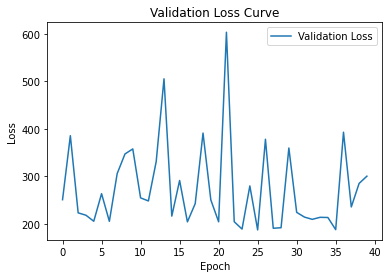

In [96]:
import matplotlib.pyplot as plt

# Plot the validation loss curve
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Validation Loss Curve')
plt.legend()
plt.show()